<h1> Imports </h1>

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import os
from random import randint

import idx2numpy
import librosa

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.svm import LinearSVC

from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, roc_curve, auc, classification_report

<h1> Working with Audio Modality </h1>

In [2]:
# Gathering list of files to dynamically iterate through
audioFiles = np.array([filename for filename in os.listdir("datasets/recordings")])
len(audioFiles)

3000

<h3>Exploratory data analysis of audio dataset</h3>

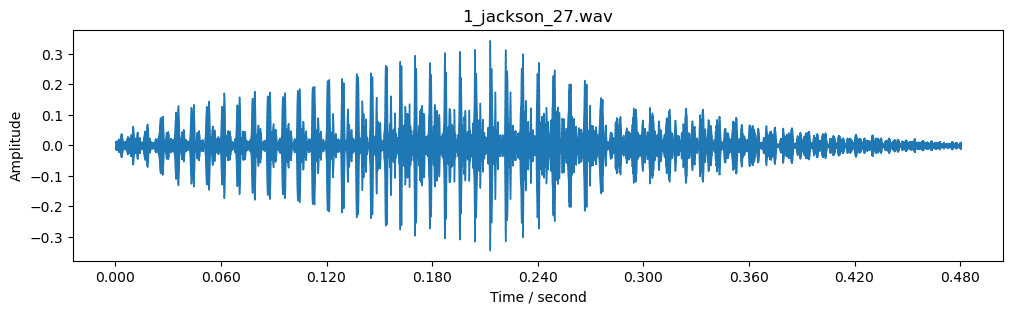

Frequencies:
[0.00000000e+00 2.08156330e+00 4.16312659e+00 ... 2.20437553e+04
 2.20458369e+04 2.20479184e+04]


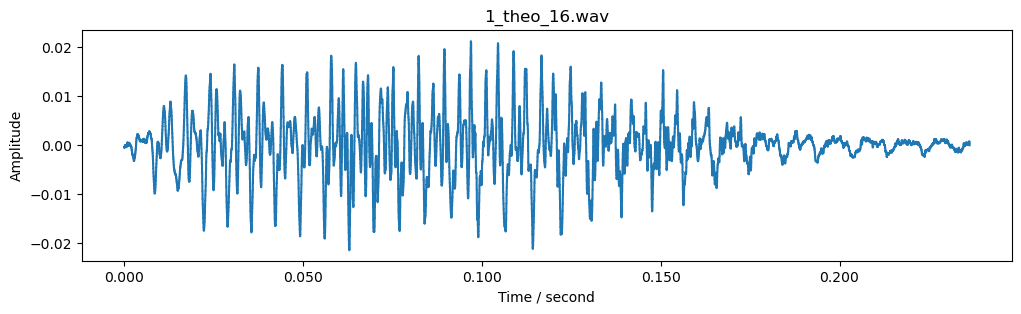

Frequencies:
[0.00000000e+00 4.22981009e+00 8.45962018e+00 ... 2.20373106e+04
 2.20415404e+04 2.20457702e+04]


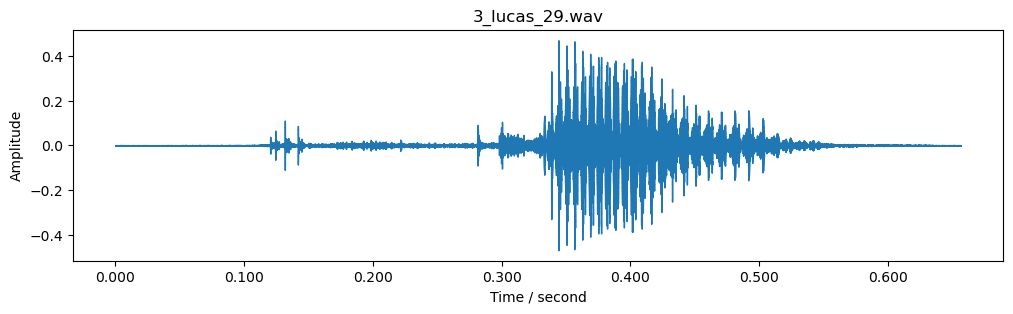

Frequencies:
[0.00000000e+00 1.52321083e+00 3.04642166e+00 ... 2.20454304e+04
 2.20469536e+04 2.20484768e+04]


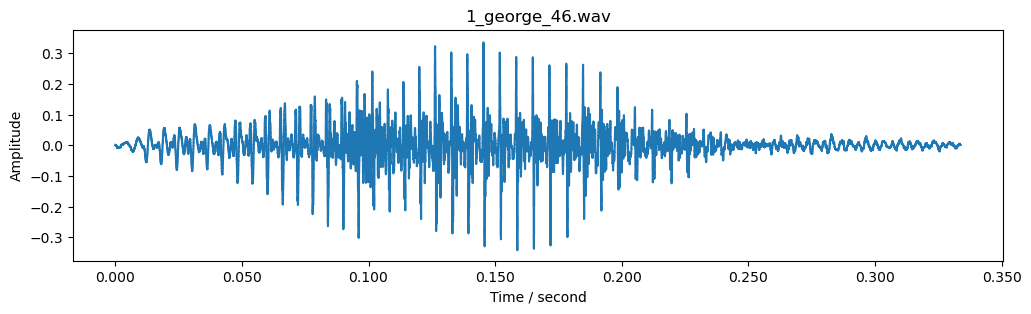

Frequencies:
[0.00000000e+00 2.99511002e+00 5.99022005e+00 ... 2.20410147e+04
 2.20440098e+04 2.20470049e+04]


In [3]:
# Randomly sample and display the waves and frequencies of 4 recordings in our dataset
randInt = [randint(0, 3000) for i in range(4)]
for i in range(4):
    signal, sample_rate = librosa.load("./datasets/recordings/" + audioFiles[randInt[i]])

    plt.figure(i, figsize=(12,3))
    librosa.display.waveshow(y=signal, sr=sample_rate)
    plt.xlabel('Time / second')
    plt.ylabel('Amplitude')
    plt.title(audioFiles[randInt[i]])
    plt.show()

    k = np.arange(len(signal))
    T = len(signal)/sample_rate
    print("Frequencies:")
    print(k/T)

<h3>Audio feature extraction</h3>
We focus on extracting the audio features of Mel-frequency cepstral coefficients (MFCCs), Zero Crossing Rate (ZCR), and Mel Spectrogram. These are key features for determining audio and speech recognition.

In [4]:
# Feature Extraction
mfccList, zcrList, mel_specList = [], [], []

for i in audioFiles:
    signal, sample_rate = librosa.load("./datasets/recordings/" + i)
    
    df_mfccs = pd.DataFrame()
    df_zero_crossing_rate = pd.DataFrame()
    df_mel_spectrogram = pd.DataFrame()
    
    mfccs = librosa.feature.mfcc(y=signal, sr=sample_rate, n_mfcc=7)
    for n_mfcc in range(len(mfccs)):
        df_mfccs['MFCC_%d'%(n_mfcc+1)] = mfccs.T[n_mfcc]
    
    zcr = librosa.feature.zero_crossing_rate(y=signal)
    df_zero_crossing_rate['ZCR'] = zcr[0]

    mel_spectrogram = librosa.feature.melspectrogram(y=signal, sr=sample_rate, n_mels=7)
    for n_mel in range(len(mel_spectrogram)):
        df_mel_spectrogram['Mel_Spectrogram_%d'%(n_mel+1)] = mel_spectrogram.T[n_mel]
        
    mfccList.append(df_mfccs)
    zcrList.append(df_zero_crossing_rate)
    mel_specList.append(df_mel_spectrogram)

len(zcrList)

3000

In [5]:
# Defined helper function
def average(list):    
    if (list is None):
        return list
    
    sum = 0
    for i in list:
        sum = sum + i
    sum = sum / len(list)
    return sum

In [6]:
for i in range(len(zcrList)):
    if (len(zcrList[i]) > 20):
        zcrList[i] = zcrList[i][0:20]
    else:
        avg = average(zcrList[i].to_numpy())
        while (len(zcrList[i]) < 20):
            zcrList[i] = pd.concat([zcrList[i], pd.Series({'ZCR': avg}).to_frame().T], ignore_index=True)

In [7]:
mfccData = [average(i.to_numpy()) for i in mfccList]
mel_specData = [average(i.to_numpy()) for i in mel_specList]
audioDigits = [(i.split('_')[0]) for i in audioFiles]

zcrData = [i.to_numpy() for i in zcrList]
zcrExtraction = [[x[0] for x in zcrData[i]] for i in range(len(zcrData))]

In [8]:
audioDF = pd.DataFrame(data={"mfcc": mfccData, "zcr": zcrExtraction, "mel_spec": mel_specData, "digit": audioDigits})
audioDF.head()

,mfcc,zcr,mel_spec,digit
0,"[-7.1749105, -9.814416, -32.84152, -33.143135,...","[0.0400390625, 0.0654296875, 0.08642578125, 0....","[0.67959493, 2.6410697, 2.7626953, 2.2315855, ...",0
1,"[-36.637814, -32.941685, -39.765564, -40.27858...","[0.01171875, 0.0205078125, 0.03125, 0.04980468...","[0.027008554, 0.096804574, 0.08299069, 0.06056...",0
2,"[-66.113396, -67.84639, -69.37728, -69.64814, ...","[0.09521484375, 0.140625, 0.18017578125, 0.170...","[0.0022103908, 0.00081152195, 0.0001371109, 7....",0
3,"[-39.87271, -37.52598, -43.69968, -40.484066, ...","[0.02099609375, 0.0419921875, 0.06005859375, 0...","[0.006640947, 0.023514003, 0.061680716, 0.3183...",0
4,"[-33.908897, -31.436893, -39.28232, -40.75008,...","[0.01806640625, 0.02978515625, 0.0556640625, 0...","[0.02909206, 0.08860803, 0.10671849, 0.1544902...",0


In [9]:
def explode_array_column(row, title):
    return pd.Series(row[title])

scale = StandardScaler()

explodedMFCC = audioDF.apply(lambda x: explode_array_column(x, 'mfcc'), axis=1)
explodedMFCC.columns = ['mfcc_{}'.format(i) for i in range(explodedMFCC.shape[1])]
explodedMFCC_scaledDF = pd.DataFrame(scale.fit_transform(explodedMFCC), columns=explodedMFCC.columns)

explodedZCR = audioDF.apply(lambda x: explode_array_column(x, 'zcr'), axis=1)
explodedZCR.columns = ['zcr_{}'.format(i) for i in range(explodedZCR.shape[1])]
explodedZCR_scaledDF = pd.DataFrame(scale.fit_transform(explodedZCR), columns=explodedZCR.columns)

explodedMelSpec = audioDF.apply(lambda x: explode_array_column(x, 'mel_spec'), axis=1)
explodedMelSpec.columns = ['mel_spec_{}'.format(i) for i in range(explodedMelSpec.shape[1])]
explodedMelSpec_scaledDF = pd.DataFrame(scale.fit_transform(explodedMelSpec), columns=explodedMelSpec.columns)


newAudioDF = pd.concat([audioDF, explodedMFCC_scaledDF], axis=1)
newAudioDF = pd.concat([newAudioDF, explodedZCR_scaledDF], axis=1)
newAudioDF = pd.concat([newAudioDF, explodedMelSpec_scaledDF], axis=1)
newAudioDF = newAudioDF.drop('mfcc', axis=1)
newAudioDF = newAudioDF.drop('zcr', axis=1)
newAudioDF = newAudioDF.drop('mel_spec', axis=1)

newAudioDF.head()

,digit,mfcc_0,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,zcr_0,zcr_1,...,zcr_17,zcr_18,zcr_19,mel_spec_0,mel_spec_1,mel_spec_2,mel_spec_3,mel_spec_4,mel_spec_5,mel_spec_6
0,0,2.020878,1.715613,0.549207,0.418089,0.202564,0.101085,0.060731,-0.452468,-0.311971,...,-0.110489,-0.134716,-0.161120,2.309131,2.502468,1.395426,0.698813,0.745815,0.399254,-0.100748
1,0,0.655941,0.561488,0.163528,-0.006810,-0.233597,-0.195099,-0.173995,-1.179224,-1.134656,...,-0.326920,-0.472166,-0.497477,-0.218768,-0.269136,-0.382493,-0.461239,-0.510522,-0.510625,-0.370917
2,0,-0.709582,-1.180369,-1.485883,-1.755698,-2.129058,-2.321417,-2.306921,0.963452,1.065133,...,0.597106,0.439113,0.298540,-0.314828,-0.373706,-0.437465,-0.493558,-0.531900,-0.556825,-0.587626
3,0,0.506077,0.332717,-0.055607,-0.019046,-0.064857,-0.261691,-0.451405,-0.941149,-0.741198,...,-0.659155,-0.737073,-0.911843,-0.297666,-0.348975,-0.396632,-0.323512,-0.165838,-0.120261,-0.174916
4,0,0.782365,0.636582,0.190446,-0.034886,-0.209802,-0.199309,-0.335546,-1.016330,-0.964754,...,-0.856419,-1.023172,-1.042695,-0.210698,-0.278065,-0.366751,-0.411050,-0.369157,-0.220507,-0.111926


In [10]:
x = newAudioDF.drop('digit', axis = 1).to_numpy()
y = newAudioDF['digit'].to_numpy()

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2)

<h3>Fit various multi-class classifiers to the training data and evaluate model</h3>

In [11]:
rfc = RandomForestClassifier()
rfc.fit(x_train, y_train)

rfc_predicted = rfc.predict(x_test)
rfc_pred_proba = rfc.predict_proba(x_test)

print(classification_report(y_test, rfc_predicted))

              precision    recall  f1-score   support

           0       0.77      0.83      0.80        59
           1       0.85      0.76      0.80        58
           2       0.77      0.90      0.83        61
           3       0.69      0.73      0.71        67
           4       0.84      0.82      0.83        57
           5       0.79      0.70      0.74        74
           6       0.85      0.82      0.84        62
           7       0.87      0.73      0.79        55
           8       0.72      0.76      0.74        51
           9       0.80      0.86      0.83        56

    accuracy                           0.79       600
   macro avg       0.79      0.79      0.79       600
weighted avg       0.79      0.79      0.79       600



In [12]:
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(x_train, y_train)

neigh_predicted = neigh.predict(x_test)
neigh_pred_proba = neigh.predict_proba(x_test)

print(classification_report(y_test, neigh_predicted))

              precision    recall  f1-score   support

           0       0.63      0.81      0.71        59
           1       0.79      0.76      0.77        58
           2       0.79      0.87      0.83        61
           3       0.66      0.73      0.70        67
           4       0.66      0.79      0.72        57
           5       0.76      0.65      0.70        74
           6       0.92      0.79      0.85        62
           7       0.94      0.58      0.72        55
           8       0.69      0.71      0.70        51
           9       0.81      0.82      0.81        56

    accuracy                           0.75       600
   macro avg       0.77      0.75      0.75       600
weighted avg       0.77      0.75      0.75       600



In [13]:
nbc = GaussianNB()
nbc.fit(x_train, y_train)

nbc_predicted = nbc.predict(x_test)
nbc_pred_proba = nbc.predict_proba(x_test)

print(classification_report(y_test, nbc_predicted))

              precision    recall  f1-score   support

           0       0.31      0.61      0.41        59
           1       0.16      0.19      0.17        58
           2       0.42      0.64      0.51        61
           3       0.43      0.15      0.22        67
           4       0.34      0.39      0.36        57
           5       0.52      0.18      0.26        74
           6       0.48      0.69      0.57        62
           7       0.40      0.15      0.21        55
           8       0.41      0.22      0.28        51
           9       0.32      0.43      0.37        56

    accuracy                           0.36       600
   macro avg       0.38      0.36      0.34       600
weighted avg       0.39      0.36      0.34       600



In [17]:
svc = SVC(probability=True)
svc.fit(x_train, y_train)

svc_predicted = svc.predict(x_test)
svc_pred_proba = svc.predict_proba(x_test)

print(classification_report(y_test, svc_predicted))

              precision    recall  f1-score   support

           0       0.47      0.68      0.56        59
           1       0.72      0.57      0.63        58
           2       0.84      0.85      0.85        61
           3       0.55      0.58      0.57        67
           4       0.67      0.75      0.71        57
           5       0.77      0.62      0.69        74
           6       0.88      0.69      0.77        62
           7       0.73      0.44      0.55        55
           8       0.67      0.63      0.65        51
           9       0.54      0.79      0.64        56

    accuracy                           0.66       600
   macro avg       0.68      0.66      0.66       600
weighted avg       0.68      0.66      0.66       600



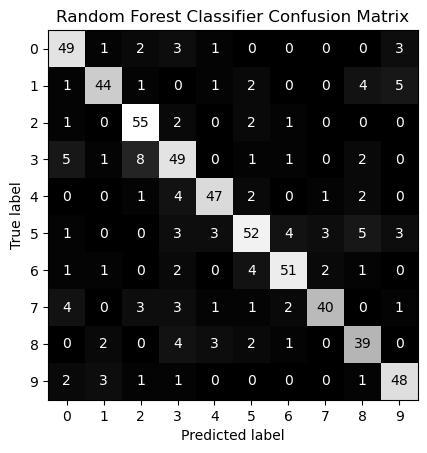

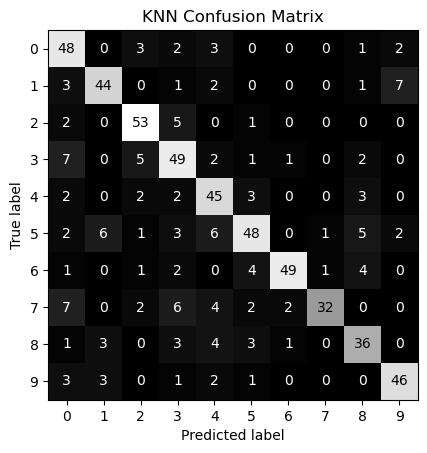

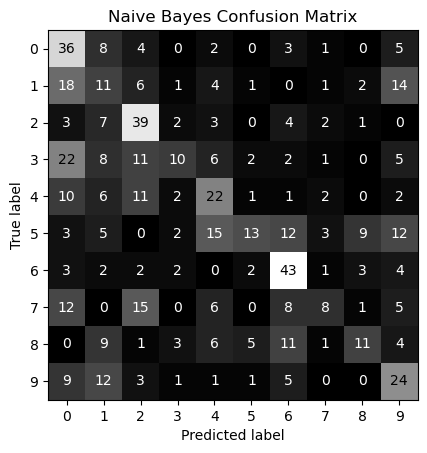

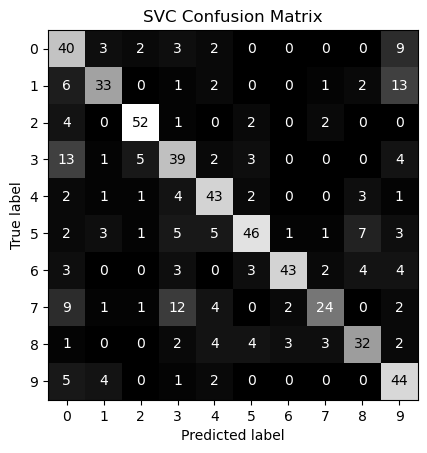

<Figure size 3000x1500 with 0 Axes>

In [18]:
models = ['Random Forest Classifier', 'KNN', 'Naive Bayes', 'SVC']
predictions = [rfc_predicted, neigh_predicted, nbc_predicted, svc_predicted]
pred_probabilities = [rfc_pred_proba, neigh_pred_proba, nbc_pred_proba, svc_pred_proba]

plot = 1

for model, prediction, pred_proba in zip(models, predictions, pred_probabilities):
    disp = ConfusionMatrixDisplay(confusion_matrix(y_test.ravel(), prediction))
    disp.plot(
        include_values=True,
        cmap='gray',
        colorbar=False
    )
    disp.ax_.set_title(f"{model} Confusion Matrix")

plt.figure(figsize=(30, 15))
plt.suptitle("ROC Curves")
plot_index = 1

<h1> Working with Visual Modality </h1>

<h3>Exploratory data analysis of visual dataset</h3>
Randomly sample dataset to check for discrepancies.

Number of Test Images: 10000
Number of Test Labels: 10000
Test Label 1680: 4


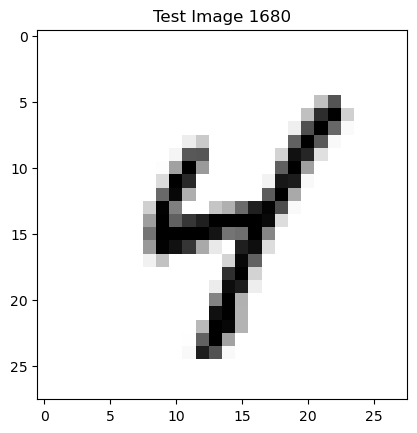

Num of Train Labels: 60000
Num of Train Images: 60000
Train Label 1680: 1


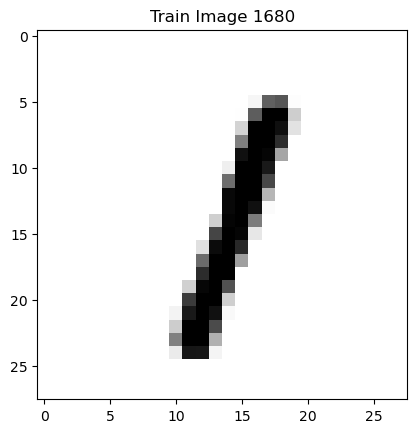

In [19]:
randnum = randint(0,10000)

file = 'datasets/numbers/t10k-labels.idx1-ubyte'
testLabels = idx2numpy.convert_from_file(file)

imagefile = 'datasets/numbers/t10k-images.idx3-ubyte'
testImages = idx2numpy.convert_from_file(imagefile)

print('Number of Test Images:', len(testImages))
print('Number of Test Labels:', len(testLabels))

print('Test Label {}:'.format(randnum), testLabels[randnum])

plt.imshow(testImages[randnum], cmap=plt.cm.binary)
plt.title('Test Image {}'.format(randnum))
plt.show()

file = 'datasets/numbers/train-labels.idx1-ubyte'
trainLabels = idx2numpy.convert_from_file(file)

imagefile = 'datasets/numbers/train-images.idx3-ubyte'
trainImages = idx2numpy.convert_from_file(imagefile)

print('Num of Train Labels:', len(trainLabels))
print('Num of Train Images:', len(trainImages))

print('Train Label {}:'.format(randnum), trainLabels[randnum])

plt.imshow(trainImages[randnum], cmap=plt.cm.binary)
plt.title('Train Image {}'.format(randnum))
plt.show()

Create histograms to visualize distribution of dataset.

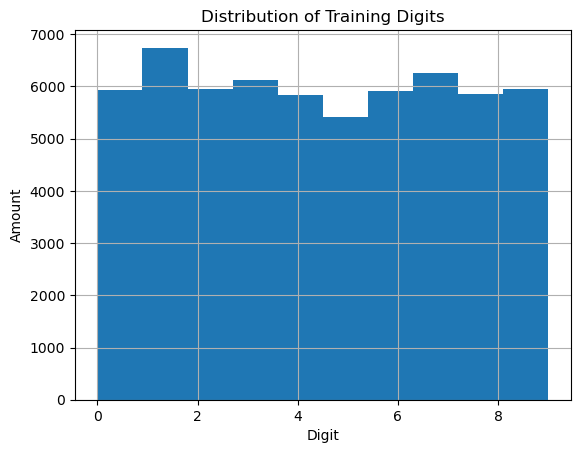

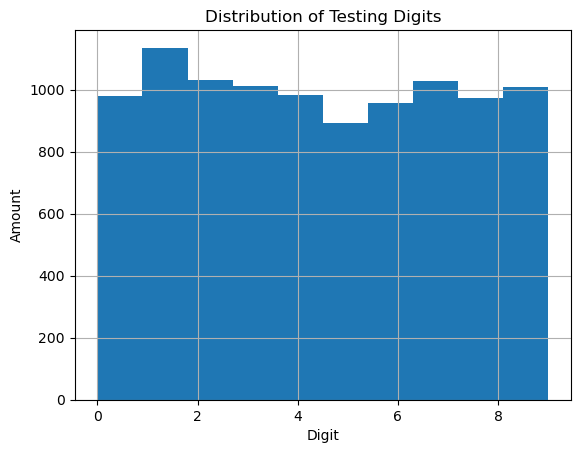

In [20]:
trainLabelsDf = pd.DataFrame(trainLabels, columns=['Digit'])

trainLabelsDf.hist(column=['Digit'])
plt.title('Distribution of Training Digits')
plt.xlabel('Digit')
plt.ylabel('Amount')
plt.show()

testLabelsDf = pd.DataFrame(testLabels, columns=['Digit'])

testLabelsDf.hist(column=['Digit'])
plt.title('Distribution of Testing Digits')
plt.xlabel('Digit')
plt.ylabel('Amount')
plt.show()

<h3>Visual feature extraction</h3>
Each Images is a 2D vector of pixels (28 * 28). We can scale these vectors by dividing by 255.
The resulting vector will have values between 0-1.


In [21]:
print('Unprocessed Row:\n', trainImages[90][15])
print('Processed Row:\n', trainImages[90][15]/255)

# We apply the scaling to the entire datasets
trainImages = trainImages/255
testImages = testImages/255

Unprocessed Row:
 [  0   0   0   0   0   0   0 157 253 253 229  32   0 154 250 246  36   0
  49 253 253 168   0   0   0   0   0   0]
Processed Row:
 [0.         0.         0.         0.         0.         0.
 0.         0.61568627 0.99215686 0.99215686 0.89803922 0.1254902
 0.         0.60392157 0.98039216 0.96470588 0.14117647 0.
 0.19215686 0.99215686 0.99215686 0.65882353 0.         0.
 0.         0.         0.         0.        ]


In [22]:
print('Sample Processed Row:\n', trainImages[90][15])

Sample Processed Row:
 [0.         0.         0.         0.         0.         0.
 0.         0.61568627 0.99215686 0.99215686 0.89803922 0.1254902
 0.         0.60392157 0.98039216 0.96470588 0.14117647 0.
 0.19215686 0.99215686 0.99215686 0.65882353 0.         0.
 0.         0.         0.         0.        ]


In [23]:
trainImages2 = []
for i in range(60000):
    trainImages2.append(np.resize(trainImages[i], (1,(28*28))))
    trainImages2[i] = trainImages2[i][0]
testImages2 = []
for i in range(10000):
    testImages2.append(np.resize(testImages[i], (1,(28*28))))
    testImages2[i] = testImages2[i][0]

In [24]:
d = {'digits': trainLabels, 'Pixels': trainImages2}
trainFrame = pd.DataFrame(data=d)
trainFrame = trainFrame.sort_values(by='digits')
trainFrame = trainFrame.reset_index()
trainFrame = trainFrame.drop('index', axis=1)
d = {'digits': testLabels, 'Pixels': testImages2}
testFrame = pd.DataFrame(data=d)
testFrame = testFrame.sort_values(by='digits').reset_index().drop('index', axis=1)

In [25]:
explodedPixelsTrain = trainFrame.apply(lambda x: explode_array_column(x,'Pixels'), axis=1)
explodedPixelsTrain.columns = ['Pixel_{}'.format(i) for i in range((28*28))]
explodedPixelsTrain = pd.concat([trainFrame['digits'], explodedPixelsTrain], axis=1)

explodedPixelsTest = testFrame.apply(lambda x: explode_array_column(x,'Pixels'), axis=1)
explodedPixelsTest.columns = ['Pixel_{}'.format(i) for i in range((28*28))]
explodedPixelsTest = pd.concat([testFrame['digits'], explodedPixelsTest], axis=1)

In [26]:
y = explodedPixelsTrain['digits'].to_numpy()
X = explodedPixelsTrain.drop('digits', axis=1).to_numpy()

X_test = explodedPixelsTest.drop('digits', axis=1).to_numpy()
y_test = explodedPixelsTest['digits'].to_numpy()

<h3>Visual Model Training</h3>

In [27]:
# Y data will be the labels for each index of the array
# X data will be the pixel information for each image, along with audio features.
svc = LinearSVC(max_iter=3000)
neigh = KNeighborsClassifier(n_neighbors=3)
nbc = GaussianNB()
rfc = RandomForestClassifier()

In [28]:
svc.fit(X, y)
neigh.fit(X, y)
nbc.fit(X, y)
rfc.fit(X, y)

C:\Users\twinb\.conda\envs\audioModalities\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


RandomForestClassifier()

In [29]:
y_knn_predicted = neigh.predict(X_test)
y_knn_pred_proba = neigh.predict_proba(X_test)

y_nbc_predicted = nbc.predict(X_test)
y_nbc_pred_proba = nbc.predict_proba(X_test)

y_rfc_predicted = rfc.predict(X_test)
y_rfc_pred_proba = rfc.predict_proba(X_test)

y_svc_predicted = svc.predict(X_test)

In [30]:
print(classification_report(y_test, y_knn_predicted))
print(classification_report(y_test, y_nbc_predicted))
print(classification_report(y_test, y_rfc_predicted))
print(classification_report(y_test, y_svc_predicted))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.96      1.00      0.98      1135
           2       0.98      0.97      0.97      1032
           3       0.96      0.97      0.96      1010
           4       0.98      0.97      0.97       982
           5       0.97      0.96      0.96       892
           6       0.98      0.99      0.98       958
           7       0.96      0.96      0.96      1028
           8       0.99      0.94      0.96       974
           9       0.96      0.96      0.96      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000

              precision    recall  f1-score   support

           0       0.79      0.89      0.84       980
           1       0.85      0.95      0.90      1135
           2       0.90      0.26      0.40      1032
           3       0.71 

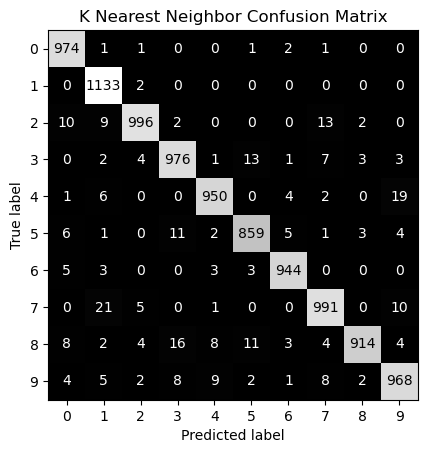

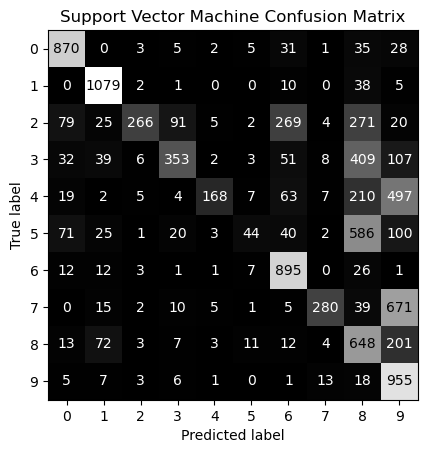

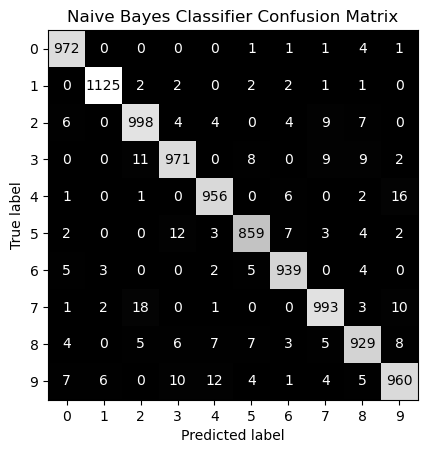

In [31]:
models = ['K Nearest Neighbor','Support Vector Machine', 'Naive Bayes Classifier', 'Random Forest Classifier']
predictions = [y_knn_predicted, y_nbc_predicted, y_rfc_predicted]
pred_probabilities = [ y_knn_pred_proba, y_nbc_pred_proba, y_rfc_pred_proba]

plot = 1

for model, prediction, pred_proba in zip(models, predictions, pred_probabilities):
    disp = ConfusionMatrixDisplay(confusion_matrix(y_test.ravel(), prediction))
    disp.plot(
        include_values=True,
        cmap='gray',
        colorbar=False
    )
    disp.ax_.set_title(f"{model} Confusion Matrix")

# Fusion Training

In [32]:
accessed = [0,0,0,0,0,0,0,0,0,0]

container = pd.DataFrame()
explodedPixelsTrain['digit'] = pd.to_numeric(explodedPixelsTrain['digit'])
newAudioDF['digit'] = pd.to_numeric(newAudioDF['digit'])

for index, row in explodedPixelsTrain.iterrows():
    accessed[int(row['digit'])] = accessed[int(row['digit'])] + 1
    audIndex = int(300 * row['digit'] + accessed[int(row['digit'])] % 300)
    
    row1 = newAudioDF.iloc[audIndex:audIndex+1].copy()
    row2 = explodedPixelsTrain.iloc[index:index+1].copy()
    fusedRow = row1.merge(row2, how="right", on="digit")

    container = pd.concat([container, fusedRow])


In [34]:
x = container.drop("digit", axis=1).to_numpy()
y = container['digit'].to_numpy()

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

In [35]:
rfc = RandomForestClassifier()
rfc.fit(x_train, y_train)

rfc_predicted = rfc.predict(x_test)
rfc_pred_proba = rfc.predict_proba(x_test)

print(classification_report(y_test, rfc_predicted))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1178
           1       0.98      0.99      0.98      1360
           2       0.96      0.97      0.97      1142
           3       0.96      0.96      0.96      1208
           4       0.98      0.98      0.98      1127
           5       0.97      0.97      0.97      1101
           6       0.98      0.98      0.98      1180
           7       0.98      0.98      0.98      1331
           8       0.97      0.95      0.96      1162
           9       0.96      0.96      0.96      1211

    accuracy                           0.97     12000
   macro avg       0.97      0.97      0.97     12000
weighted avg       0.97      0.97      0.97     12000



In [36]:
neigh = KNeighborsClassifier(n_neighbors=15)
neigh.fit(x_train, y_train)

neigh_predicted = neigh.predict(x_test)
neigh_pred_proba = neigh.predict_proba(x_test)

print(classification_report(y_test, neigh_predicted))

              precision    recall  f1-score   support

           0       0.99      0.98      0.99      1178
           1       0.92      1.00      0.96      1360
           2       1.00      0.98      0.99      1142
           3       0.99      0.97      0.98      1208
           4       0.99      0.99      0.99      1127
           5       0.99      0.95      0.97      1101
           6       0.99      0.99      0.99      1180
           7       0.99      0.99      0.99      1331
           8       0.99      0.96      0.98      1162
           9       0.97      0.98      0.98      1211

    accuracy                           0.98     12000
   macro avg       0.98      0.98      0.98     12000
weighted avg       0.98      0.98      0.98     12000



In [37]:
nbc = GaussianNB()
nbc.fit(x_train, y_train)

nbc_predicted = nbc.predict(x_test)
nbc_pred_proba = nbc.predict_proba(x_test)

print(classification_report(y_test, nbc_predicted))

              precision    recall  f1-score   support

           0       0.83      0.91      0.87      1178
           1       0.77      0.95      0.85      1360
           2       0.86      0.45      0.59      1142
           3       0.80      0.58      0.67      1208
           4       0.85      0.37      0.51      1127
           5       0.71      0.14      0.23      1101
           6       0.73      0.94      0.83      1180
           7       0.94      0.47      0.63      1331
           8       0.35      0.69      0.47      1162
           9       0.46      0.92      0.62      1211

    accuracy                           0.65     12000
   macro avg       0.73      0.64      0.63     12000
weighted avg       0.73      0.65      0.63     12000



In [38]:
svc = LinearSVC()
svc.fit(x_train, y_train)

svc_predicted = svc.predict(x_test)

print(classification_report(y_test, svc_predicted))

              precision    recall  f1-score   support

           0       0.98      0.86      0.92      1178
           1       0.98      0.92      0.95      1360
           2       0.90      0.92      0.91      1142
           3       0.97      0.62      0.75      1208
           4       0.98      0.67      0.80      1127
           5       0.37      0.98      0.54      1101
           6       0.98      0.80      0.88      1180
           7       0.96      0.85      0.91      1331
           8       0.89      0.72      0.80      1162
           9       0.94      0.76      0.84      1211

    accuracy                           0.81     12000
   macro avg       0.90      0.81      0.83     12000
weighted avg       0.90      0.81      0.83     12000



C:\Users\twinb\.conda\envs\audioModalities\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


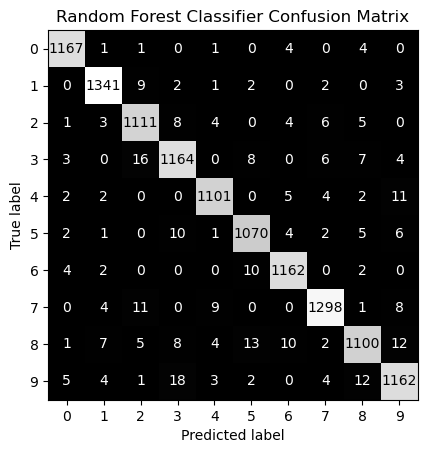

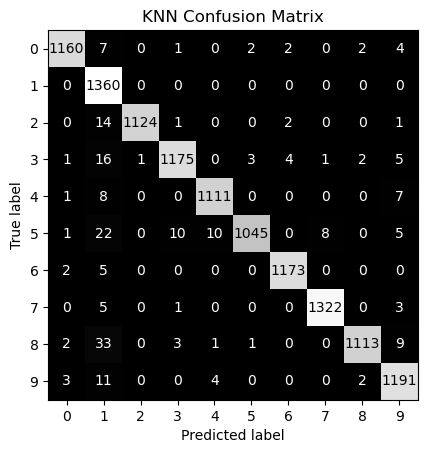

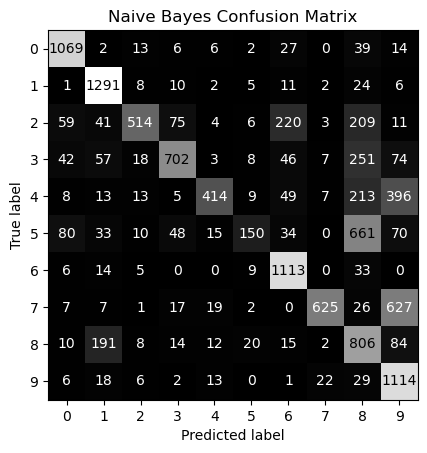

<Figure size 3000x1500 with 0 Axes>

In [39]:
models = ['Random Forest Classifier', 'KNN', 'Naive Bayes', 'SVC']
predictions = [rfc_predicted, neigh_predicted, nbc_predicted, svc_predicted]
pred_probabilities = [rfc_pred_proba, neigh_pred_proba, nbc_pred_proba]

plot = 1

for model, prediction, pred_proba in zip(models, predictions, pred_probabilities):
    disp = ConfusionMatrixDisplay(confusion_matrix(y_test.ravel(), prediction))
    disp.plot(
        include_values=True,
        cmap='gray',
        colorbar=False
    )
    disp.ax_.set_title(f"{model} Confusion Matrix")

plt.figure(figsize=(30, 15))
plt.suptitle("ROC Curves")
plot_index = 1